<a href="https://colab.research.google.com/github/bkk443/IgGM_2025/blob/master/Colab_IgGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

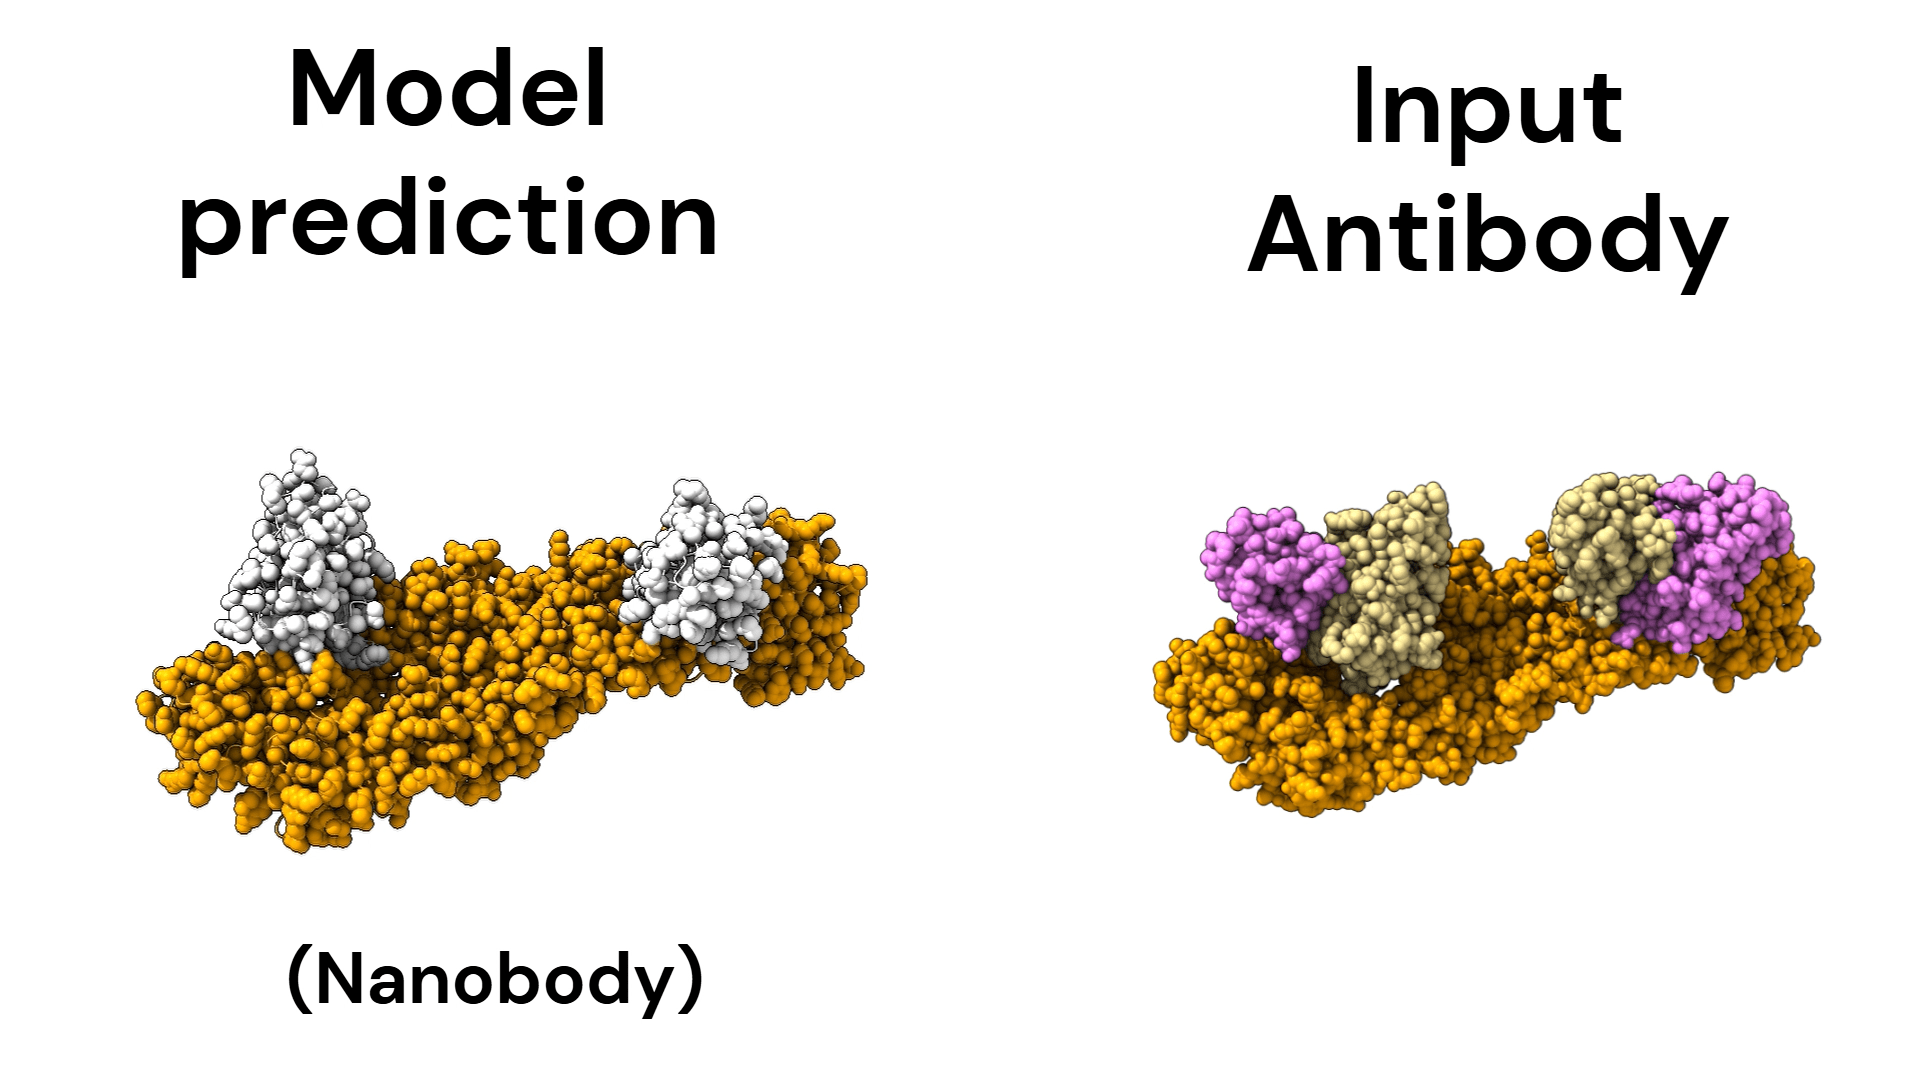

## Colab-IgGM v1.1.2
Easy to use Functional Antibody and Nanobody Design using IgGM. Optional output relaxation is done through PyRosetta. Antibody and nanobody chain identification and numbering is done using ANARCI. Epitope calculation for antigen only is done using the external server SEPPA 3.0 For more details, see <a href="#scrollTo=8498aedb&line=57&uniqifier=1">buttom</a>. of the notebook.

For Nanobody Screening links and instructions for NanoBinder have been adeded.

The use of this notebook is for non-commercial use only, unless you had been granted a Licence by the authors/owners of any repository, program or code used here.

In [ ]:
#@title Install condacolab, this will restart your session

!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:08
🔁 Restarting kernel...


In [ ]:
#@title Mount Google Drive (Only of you pretend to use PyRosetta to relax the output or saving your results)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install dependencies and clone repositories (Ignore all warnings to restart session)

In [ ]:
!git clone https://github.com/Lefrunila/IgGM
%cd IgGM


/bin/bash: line 1: git: command not found
[Errno 2] No such file or directory: 'IgGM'
/home/luis-figueroa


In [ ]:
!cat /content/IgGM/environment.yaml


cat: /content/IgGM/environment.yaml: No such file or directory


In [ ]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu117.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib


In [ ]:
!wget https://zenodo.org/api/records/13790269/files-archive -O params.zip
!unzip params.zip -d params


--2025-09-07 01:46:17--  https://zenodo.org/api/records/13790269/files-archive
Resolving zenodo.org (zenodo.org)... 2001:1458:d00:25::100:372, 2001:1458:d00:24::100:f6, 2001:1458:d00:61::100:2f3, ...
Connecting to zenodo.org (zenodo.org)|2001:1458:d00:25::100:372|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘params.zip’

params.zip              [                <=> ]   2.44M   455KB/s               

KeyboardInterrupt: 

In [ ]:
!pip install biopython


In [ ]:
!pip install openmm


In [ ]:
!conda install -c conda-forge pdbfixer -y


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [ ]:
!pip install termcolor


**Ignora la advertencia después de ejecutar el siguiente comando**

In [ ]:
!pip install ml-collections


Cell below is a fix to RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
!pip uninstall -y numpy scipy
!pip install numpy==1.23.5 scipy==1.9.3


In [ ]:
# Install all system-level dependencies required for ANARCI
print("Installing HMMER and build tools... (This may take a minute)")
!apt-get update -qq
!apt-get install -y hmmer build-essential -qq
print("✅ Dependencies installed.")

In [ ]:
!pip install py3Dmol

# Install Anarci?

(For chain Identification and CDR masking)

In [ ]:
# Clone the repository and install the package from the source code
print("\nCloning and installing ANARCI...")
!git clone https://github.com/oxpig/ANARCI.git
%cd ANARCI
!python3 setup.py install
%cd ..
print("✅ ANARCI installed successfully.")


Cloning and installing ANARCI...
Cloning into 'ANARCI'...
remote: Enumerating objects: 793, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 793 (delta 235), reused 197 (delta 197), pack-reused 514 (from 2)
Receiving objects: 100% (793/793), 6.52 MiB | 26.39 MiB/s, done.
Resolving deltas: 100% (454/454), done.
/content/IgGM/ANARCI
/usr/local/lib/python3.11/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
INFO: ANARCI lives in:  /usr/local/lib/python3.11/site-packages/anarci
INFO: Downloading germlines from IMGT and building HMMs...
INFO: running 'RUN_pipeline.sh', this will take a couple a minutes.
Parsed and saved Homo+sapiens HV
Parsed and saved Mus HV
Parsed and saved Rattus+norvegicus HV
Parsed and saved Oryctolagus+cuniculus HV
Parsed and saved Macaca+mulatta HV
Parsed and saved Sus+scr

# Install pyrostetta?

In [ ]:
!pip install pyrosettacolabsetup
import pyrosettacolabsetup
pyrosettacolabsetup.install_pyrosetta()

# Input file processing

In [ ]:
#@title Upload your pdb and clean all non-protein atoms

import os
import py3Dmol
from google.colab import files
import collections

# --- Helper Functions ---

def parse_and_display_metadata(pdb_data_string):
    """
    Finds, parses, and prints specific metadata (Chains and Non-standard residues).
    """
    chains = collections.OrderedDict()
    non_standard_residues = set()

    for line in pdb_data_string.splitlines():
        if line.startswith('SEQRES'):
            chain_id = line[11]
            if chain_id not in chains:
                chains[chain_id] = 0
            chains[chain_id] += len(line[19:].split())

        elif line.startswith('HETATM'):
            res_name = line[17:20].strip()
            if res_name != 'HOH': # Exclude water from the list
                non_standard_residues.add(res_name)

    print("--- 📄 PDB Information ---")
    if chains:
        print("\nChain Information:")
        for chain, res_count in chains.items():
            print(f"  Chain {chain}: {res_count} residues")

    if non_standard_residues:
        print("\nNon-standard residues found (excluding water):")
        for res in sorted(list(non_standard_residues)):
            print(f"  - {res}")
    print("------------------------")


def clean_pdb_from_string(pdb_data_string):
    """
    Takes PDB content as a string and returns a new string with only structural records.
    """
    RECORDS_TO_KEEP = ('ATOM', 'TER', 'MODEL', 'ENDMDL')
    cleaned_lines = []
    for line in pdb_data_string.splitlines():
        if line.startswith(RECORDS_TO_KEEP):
            cleaned_lines.append(line)
    return "\n".join(cleaned_lines)


def get_chain_info(pdb_data_string):
    """Parses a PDB string to find chains and their first residue number."""
    chain_info = {}
    for line in pdb_data_string.splitlines():
        if line.startswith('ATOM'):
            chain_id = line[21]
            if chain_id not in chain_info:
                try:
                    residue_number = int(line[22:26])
                    chain_info[chain_id] = residue_number
                except ValueError:
                    continue
    return chain_info

# --- Main Colab execution block ---

# 1. Create the target directory and move into it
target_folder = '/content/IgGM/inputs'
os.makedirs(target_folder, exist_ok=True)
os.chdir(target_folder)
print(f"📁 Working directory set to: '{target_folder}'")


# 2. Prompt for file upload
print("\nPlease upload the PDB file you want to process.")
uploaded = files.upload()

if not uploaded:
    print("\nNo file was uploaded. Please run the cell again.")
else:
    # 3. Define file paths and save the uploaded file
    input_filename = next(iter(uploaded))
    output_filename = f"cleaned_{input_filename}"

    # 4. Read the original file into memory
    with open(input_filename, 'r') as f:
        original_pdb_data = f.read()

    # 5. Clean the PDB data
    print("\n🧹 Cleaning PDB to keep only protein atoms...")
    cleaned_pdb_data = clean_pdb_from_string(original_pdb_data)

    # 6. Save the cleaned data to the output file
    with open(output_filename, 'w') as f:
        f.write(cleaned_pdb_data)
    print("✨ Successfully created cleaned file.")

    # 7. Display metadata and file paths
    parse_and_display_metadata(original_pdb_data)
    abs_input_path = os.path.abspath(input_filename)
    abs_output_path = os.path.abspath(output_filename)
    print("\n--- 📌 File Paths ---")
    print(f"Input file:   {abs_input_path}")
    print(f"Cleaned file: {abs_output_path}")
    print("----------------------")

    # 8. Visualization using two separate py3Dmol viewers
    original_chains = get_chain_info(original_pdb_data)

    if not cleaned_pdb_data.strip():
        print("\nError: The cleaned PDB data is empty. Cannot generate visualization.")
    else:
        print("\n--- 1. Original PDB ---")
        # --- First Viewer: Original PDB ---
        view1 = py3Dmol.view(width=800, height=400)
        view1.addModel(original_pdb_data, 'pdb')
        view1.setStyle({}, {'cartoon': {'color': 'spectrum'}})
        view1.addStyle({'hetflag': True}, {'stick': {'radius': 0.3, 'colorscheme': 'cyanCarbon'}, 'sphere': {'scale': 0.4}})
        for chain, resi in original_chains.items():
            view1.addLabel(f"Chain {chain}", {'alignment': 'topLeft', 'fontColor':'white', 'backgroundColor':'black', 'backgroundOpacity':0.6}, {'chain': chain, 'resi': resi})
        view1.zoomTo()
        view1.show()

        print("\n--- 2. Protein-Only PDB ---")
        # --- Second Viewer: Cleaned PDB ---
        view2 = py3Dmol.view(width=800, height=400)
        view2.addModel(cleaned_pdb_data, 'pdb')
        view2.setStyle({}, {'cartoon': {'color': 'spectrum'}})
        # No hetflag or label styling for the cleaned view
        view2.zoomTo()
        view2.show()

In [ ]:
#@title Remove Specific Chains from PDB
#@markdown Do this for chains that are far away from the epitope and you have certainty that do not interact with the antibody or nanobody.
#@markdown H (VH or VHH) and L (VL) chains **must** be deleted before designing/redesigning.
import os
import py3Dmol
import collections

# --- Helper Functions ---

def remove_chains_from_pdb(input_path, output_path, chains_to_remove):
    """
    Reads a PDB file and writes a new one, excluding the specified chains.
    """
    chains_set = set(chains_to_remove) # Use a set for efficient lookup
    print(f"🔄 Removing chains {', '.join(sorted(list(chains_set)))} from '{os.path.basename(input_path)}'...")

    lines_written = 0
    with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
        for line in infile:
            # Check ATOM and TER records for their chain ID
            if line.startswith(('ATOM', 'TER')):
                chain_id = line[21]
                if chain_id not in chains_set:
                    outfile.write(line)
            # Preserve other important records like metadata, but not HETATM
            elif not line.startswith('HETATM'):
                outfile.write(line)

    print(f"✅ New file saved to: {output_path}")
    return True


def get_chain_info(pdb_data_string):
    """Gets the chains and the first residue of each for labeling."""
    chain_info = collections.OrderedDict()
    for line in pdb_data_string.splitlines():
        if line.startswith('ATOM'):
            chain_id = line[21]
            if chain_id not in chain_info:
                try:
                    residue_number = int(line[22:26])
                    chain_info[chain_id] = residue_number
                except ValueError:
                    continue
    return chain_info

# --- Colab Forms ---

#@markdown ### 1. Input File
#@markdown Enter the full path to your PDB file.
input_pdb_path = "/content/IgGM/inputs/cleaned_pdb.pdb" #@param {type:"string"}

#@markdown ---
#@markdown ### 2. Chains to Remove
#@markdown Enter the chain IDs to remove, separated by commas (e.g., `H,L`).
chains_to_remove_str = "G,A,B,C" #@param {type:"string"}


# --- Main Execution Block ---

if not input_pdb_path.strip() or not os.path.exists(input_pdb_path):
    print("❌ ERROR: Please enter a valid path to a PDB file in the first box.")
else:
    # Get the list of chains to remove
    chains_to_remove = [chain.strip().upper() for chain in chains_to_remove_str.split(',')]

    # Define the output file path
    base_name = os.path.splitext(os.path.basename(input_pdb_path))[0]
    output_pdb_path = os.path.join(os.path.dirname(input_pdb_path), f"{base_name}_chains_removed.pdb")

    # --- FIX: The function call was missing its third argument and a closing parenthesis ---
    success = remove_chains_from_pdb(input_pdb_path, output_pdb_path, chains_to_remove)

    if success:
        # Read the files for visualization
        with open(input_pdb_path, 'r') as f:
            original_pdb_data = f.read()
        with open(output_pdb_path, 'r') as f:
            modified_pdb_data = f.read()

        # Get info for the labels
        original_chains = get_chain_info(original_pdb_data)
        modified_chains = get_chain_info(modified_pdb_data)

        # --- Visualization with two separate viewers ---
        print("\n--- 1. Original PDB ---")
        view1 = py3Dmol.view(width=800, height=400)
        view1.addModel(original_pdb_data, 'pdb')
        view1.setStyle({}, {'cartoon': {'colorscheme': 'chain'}})
        for chain, resi in original_chains.items():
            view1.addLabel(f"Chain {chain}", {'fontColor':'white', 'backgroundColor':'black', 'backgroundOpacity':0.7}, {'chain': chain, 'resi': resi})
        view1.zoomTo()
        view1.show()

        print("\n--- 2. PDB with Chains Removed ---")
        view2 = py3Dmol.view(width=800, height=400)
        view2.addModel(modified_pdb_data, 'pdb')
        view2.setStyle({}, {'cartoon': {'colorscheme': 'chain'}})
        for chain, resi in modified_chains.items():
            view2.addLabel(f"Chain {chain}", {'fontColor':'white', 'backgroundColor':'black', 'backgroundOpacity':0.7}, {'chain': chain, 'resi': resi})
        view2.zoomTo()
        view2.show()

# Chain Identification and CDR masking for redesign

In [ ]:
#@title Step 1 Check Input Files for Ab and/or Nb chain identification
import os

# Define the folder that should already contain your PDB files
target_folder = '/content/IgGM/inputs'

print(f"Checking for existing files in: {target_folder}\n")

if os.path.isdir(target_folder):
    # List the PDB files found in the directory
    pdb_files = [f for f in os.listdir(target_folder) if f.endswith(('.pdb', '.ent'))]

    if not pdb_files:
        print("⚠️  Folder exists, but no PDB files were found inside.")
        print("Please make sure your PDB files are in this directory.")
    else:
        print("✅  Found the following PDB files:")
        for f in pdb_files:
            print(f"  - {os.path.join(target_folder, f)}")
        print("\nYou can now copy a file path and proceed to run the analysis cell below.")

else:
    print(f"❌ ERROR: The directory '{target_folder}' does not exist.")
    print("Please create the folder and upload your PDB files before running the analysis cell.")

In [ ]:
#@title Optionaly upload more files to /content/IgGM/inputs
import os
from google.colab import files
import shutil

# 1. Define and create the target directory
target_folder = '/content/IgGM/inputs'
os.makedirs(target_folder, exist_ok=True)
print(f"📁 Directory '{target_folder}' is ready.")

# 2. Change into the target directory
os.chdir(target_folder)
print(f"✅ Current directory changed to: {os.getcwd()}")


# 3. Prompt for file upload
print("\nPlease choose the file(s) to upload:")
uploaded = files.upload()

if not uploaded:
    print("\nNo file was uploaded.")
else:
    print("\n✅ Upload complete. The following files are now in your inputs folder:")
    for filename in uploaded.keys():
        print(f"  - {filename}")

# Optional: Change back to the default content directory
os.chdir('/content')

In [ ]:
#@title Step 2: Select File and Classify Chains
import os
import re
import subprocess
from Bio.PDB import PDBParser, Polypeptide
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import warnings
import collections

# Suppress Biopython warnings for cleaner output
warnings.simplefilter('ignore', PDBConstructionWarning)

# --- Helper Functions ---

def extract_pdb_sequences(pdb_filepath):
    """Parses a PDB file to extract the amino acid sequence of each chain."""
    sequences = collections.OrderedDict()
    parser = PDBParser()
    structure = parser.get_structure("pdb", pdb_filepath)
    aa_map = Polypeptide.protein_letters_3to1
    for chain in structure.get_chains():
        seq = ""
        residues = {}
        for residue in chain:
            if residue.id[0] == ' ' and residue.get_resname() in aa_map:
                residues[residue.id[1:]] = aa_map[residue.get_resname()]
        if residues:
            sorted_residues = sorted(residues.items())
            sequences[chain.id] = "".join([res_char for res_id, res_char in sorted_residues])
    return sequences

def write_fasta(sequences_dict, filename):
    """Writes a dictionary of sequences to a FASTA file."""
    with open(filename, 'w') as f:
        for header, seq in sequences_dict.items():
            f.write(f">{header}\n")
            f.write(f"{seq}\n")
    print(f"📄 FASTA file with all chain sequences created: {filename}")

def classify_chains_from_fasta(fasta_filepath, original_sequences):
    """
    Runs the ANARCI command-line tool on a FASTA file and parses the output.
    """
    classifications = {chain_id: "Not an antibody variable domain" for chain_id in original_sequences}
    cmd = ["ANARCI", "-i", fasta_filepath, "--scheme", "imgt"]

    try:
        result = subprocess.run(cmd, capture_output=True, text=True, check=True)
        raw_output = result.stdout
        output_blocks = raw_output.strip().split('//')

        for block in output_blocks:
            if not block.strip(): continue

            header_match = re.search(r"^#\s*(\S+)", block.strip())
            if not header_match: continue
            chain_id = header_match.group(1)

            # --- FIX: Make the regex specific to the data line, not the header ---
            # It now skips any line where the first field is the literal word "species"
            hit_match = re.search(r"#\|(?!species)([^|]+)\|([^|]+)\|", block)
            if hit_match:
                species, domain_type = hit_match.group(1), hit_match.group(2)
                if domain_type == 'H': classifications[chain_id] = "VH (Heavy Chain Variable Domain)"
                elif domain_type == 'K': classifications[chain_id] = "VK (Kappa Light Chain Variable Domain)"
                elif domain_type == 'L': classifications[chain_id] = "VL (Lambda Light Chain Variable Domain)"
                else: classifications[chain_id] = f"Other ({domain_type})"

    except subprocess.CalledProcessError as e:
        print(f"ANARCI command failed: {e.stderr}")
        return None, None

    # Heuristic check for VHH
    vh_domains = [cid for cid, c in classifications.items() if "VH" in c]
    vl_domains = [cid for cid, c in classifications.items() if "VK" in c or "VL" in c]
    if len(vh_domains) > 0 and len(vl_domains) == 0:
        for chain_id in vh_domains:
            classifications[chain_id] = "VHH (Nanobody / Single-Domain)"

    return classifications, raw_output


# --- Main Colab execution block ---

target_folder = '/content/IgGM/inputs'
print(f"Scanning for PDB files in '{target_folder}'...")
pdb_files = [f for f in os.listdir(target_folder) if f.endswith(('.pdb', '.ent'))] if os.path.exists(target_folder) else []
if pdb_files:
    print("Found the following PDB files:")
    for f in pdb_files: print(f"  - {os.path.join(target_folder, f)}")
else:
    print("No PDB files found. Please run the setup/upload cell.")

#@markdown ---
#@markdown ### Enter the full path of the PDB file to analyze:
input_filepath = "/content/IgGM/inputs/cleaned_pdb.pdb" #@param {type:"string"}
# @markdown ### Show full ANARCI output?
show_full_anarci_output = False #@param {type:"boolean"}

if not input_filepath.strip():
    if pdb_files:
        input_filepath = os.path.join(target_folder, pdb_files[0])
        print(f"\nNo path entered, defaulting to first file found: {input_filepath}")
    else:
        print("\nNo file path entered and no PDB files found.")
        input_filepath = None
elif not os.path.exists(input_filepath):
    print(f"\n❌ ERROR: File not found at '{input_filepath}'.")
    input_filepath = None

if input_filepath:
    base_name = os.path.splitext(os.path.basename(input_filepath))[0]
    fasta_output_path = os.path.join(target_folder, f"{base_name}_sequences.fasta")

    try:
        print(f"\n🧬 Analyzing '{input_filepath}'...")
        sequences = extract_pdb_sequences(input_filepath)

        if not sequences:
            print("Could not extract any protein sequences from the PDB file.")
        else:
            write_fasta(sequences, fasta_output_path)
            classifications, raw_anarci_output = classify_chains_from_fasta(fasta_output_path, sequences)

            if classifications:
                print("\n--- 🔬 Analysis Results ---")
                for chain_id, classification in sorted(classifications.items()):
                    print(f"  Chain {chain_id}: {classification}")
                print("--------------------------")

            if show_full_anarci_output and raw_anarci_output:
                print("\n--- Full ANARCI Output ---")
                print(raw_anarci_output)
                print("--------------------------")


    except Exception as e:
        print(f"\nAn error occurred: {e}")

In [ ]:
#@title Step 3: Generate CDR-Masked FASTA File for redesign

def mask_sequences_from_anarci_output(original_sequences, classifications, raw_output):
    """
    Parses the raw ANARCI output to find CDRs and mask the original sequences.
    """
    masked_sequences = {}
    cdr_definitions = {"CDR1": (27, 38), "CDR2": (56, 65), "CDR3": (105, 117)}
    output_blocks = raw_output.strip().split('//')

    for block in output_blocks:
        if not block.strip() or not "ANARCI numbered" in block:
            continue

        header_match = re.search(r"^#\s*(\S+)", block.strip())
        chain_id = header_match.group(1)

        # Ensure this is a chain we classified as an antibody
        if chain_id not in classifications or "V" not in classifications[chain_id]:
            continue

        original_sequence_list = list(original_sequences[chain_id])
        seq_idx = 0

        # Parse the numbering lines
        for line in block.splitlines():
            # Match lines like 'H 112 A F' or 'L 27      S'
            match = re.match(r"^\s*[HKL]\s+(\d+)\s*[A-Z]?\s+([A-Z])", line)
            if match:
                res_num, amino_acid = int(match.group(1)), match.group(2)

                # Check if the IMGT number falls into a CDR region
                is_cdr = any(start <= res_num <= end for start, end in cdr_definitions.values())

                if is_cdr and seq_idx < len(original_sequence_list):
                    original_sequence_list[seq_idx] = 'X'

                # IMPORTANT: We only advance the sequence index for non-gap residues
                seq_idx += 1

        # Reconstruct the header and the masked sequence
        header = f"{classifications[chain_id].split(' ')[0]}_{chain_id}"
        masked_sequences[header] = "".join(original_sequence_list)

    return masked_sequences


if 'classifications' in locals() and classifications:
    print("Generating CDR-masked sequences...")
    # Define masked_output_path before using it
    base_name = os.path.splitext(os.path.basename(input_filepath))[0]
    masked_output_path = os.path.join(target_folder, f"{base_name}_masked_cdrs.fasta")

    masked_seqs = mask_sequences_from_anarci_output(sequences, classifications, raw_anarci_output)

    if masked_seqs:
        write_fasta(masked_seqs, masked_output_path)
    else:
        print("No antibody variable domains were found to mask.")
else:
    print("⚠️ Please run Cell 2 first to analyze a PDB file.")

Generating CDR-masked sequences...
📄 FASTA file with all chain sequences created: /content/IgGM/inputs/cleaned_7eow_masked_cdrs.fasta


In [ ]:
#@title Rename PDB Chains for IgGM
import os
import py3Dmol
import collections

# --- Helper Functions ---

def rename_pdb_chains(input_path, output_path, chain_map):
    """
    Reads a PDB file and creates a new one with chains renamed according to the map.
    """
    if not chain_map:
        print("⚠️ No chains were specified for renaming.")
        return False

    print(f"🔄 Renaming chains in '{os.path.basename(input_path)}'...")
    print("Rename map:", chain_map)

    lines_written = 0
    with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
        for line in infile:
            # Only ATOM and TER lines contain the chain ID in column 22
            if line.startswith(('ATOM', 'TER   ')):
                original_chain_id = line[21]
                # If the original chain is in our map, we replace it
                new_chain_id = chain_map.get(original_chain_id, original_chain_id)
                # Reconstruct the line with the new ID
                new_line = line[:21] + new_chain_id + line[22:]
                outfile.write(new_line)
            else:
                # Write other lines (metadata, etc.) without changes
                outfile.write(line)
            lines_written += 1

    if lines_written > 0:
        print(f"✅ New file saved to: {output_path}")
        return True
    else:
        print(f"❌ Could not process the input file.")
        return False

def get_chain_info(pdb_data_string):
    """Gets the chains and the first residue of each for labeling."""
    chain_info = collections.OrderedDict()
    for line in pdb_data_string.splitlines():
        if line.startswith('ATOM'):
            chain_id = line[21]
            if chain_id not in chain_info:
                try:
                    residue_number = int(line[22:26])
                    chain_info[chain_id] = residue_number
                except ValueError:
                    continue
    return chain_info

# --- Colab Forms ---

#@markdown ### 1. Enter the PDB File Path
#@markdown (This should be a protein-only file, without ligands or water).
input_pdb_path = "/content/IgGM/inputs/cleaned_your_pdb.pdb" #@param {type:"string"}

#@markdown ---
#@markdown ### 2. Define Chains to Rename
#@markdown Enter the ID of the chain you want to rename to **H** (VH or VHH).
chain_to_rename_H = "C" #@param {type:"string"}

#@markdown Enter the ID of the chain you want to rename to **L** (VL) (Optional).
chain_to_rename_L = "B" #@param {type:"string"}


# --- Main Execution Block ---

if not input_pdb_path.strip() or not os.path.exists(input_pdb_path):
    print("❌ ERROR: Please enter a valid path to a PDB file in the first box.")
elif not chain_to_rename_H.strip():
    print("❌ ERROR: You must specify a chain to rename to 'H'.")
else:
    # Build the map of chains to rename
    chain_map = {}
    if chain_to_rename_H.strip():
        chain_map[chain_to_rename_H.strip()] = 'H'
    if chain_to_rename_L.strip():
        chain_map[chain_to_rename_L.strip()] = 'L'

    # Define the output file path
    base_name = os.path.splitext(os.path.basename(input_pdb_path))[0]
    output_pdb_path = os.path.join(os.path.dirname(input_pdb_path), f"{base_name}_renamed.pdb")

    # Execute the renaming
    success = rename_pdb_chains(input_pdb_path, output_pdb_path, chain_map)

    if success:
        # Read the files for visualization
        with open(input_pdb_path, 'r') as f:
            original_pdb_data = f.read()
        with open(output_pdb_path, 'r') as f:
            renamed_pdb_data = f.read()

        # Get info for the labels
        original_chains = get_chain_info(original_pdb_data)
        renamed_chains = get_chain_info(renamed_pdb_data)

        # --- Visualization with two separate viewers ---
        print("\n--- 1. Original PDB ---")
        view1 = py3Dmol.view(width=800, height=400)
        view1.addModel(original_pdb_data, 'pdb')
        view1.setStyle({}, {'cartoon': {'colorscheme': 'chain'}}) # <-- Color by chain
        for chain, resi in original_chains.items():
            view1.addLabel(f"Chain {chain}", {'fontColor':'white', 'backgroundColor':'black', 'backgroundOpacity':0.7}, {'chain': chain, 'resi': resi})
        view1.zoomTo()
        view1.show()

        print("\n--- 2. Renamed PDB ---")
        view2 = py3Dmol.view(width=800, height=400)
        view2.addModel(renamed_pdb_data, 'pdb')
        view2.setStyle({}, {'cartoon': {'colorscheme': 'chain'}}) # <-- Color by chain
        for chain, resi in renamed_chains.items():
            view2.addLabel(f"Chain {chain}", {'fontColor':'white', 'backgroundColor':'black', 'backgroundOpacity':0.7}, {'chain': chain, 'resi': resi})
        view2.zoomTo()
        view2.show()

# Chain merging and epitope identification
 Option 1 - You **HAVE** an Antigen-Antibody/Nanobody complex and antigen has more than 1 chain: Run only the first two cells.

 Option 2 - You **DO NOT HAVE** an Antigen-Antibody/Nanobody complex, only antigen: Run the first cell, see instructions after second cell

In [ ]:
#@title Merge chains, generate pre-input FASTA and Visualize
import os
import subprocess
import py3Dmol
import collections

# --- Helper Function for Visualization ---

def get_chain_info(pdb_data_string):
    """Gets the chains and the first residue of each for labeling."""
    chain_info = collections.OrderedDict()
    for line in pdb_data_string.splitlines():
        if line.startswith('ATOM'):
            chain_id = line[21]
            if chain_id not in chain_info:
                try:
                    residue_number = int(line[22:26])
                    chain_info[chain_id] = residue_number
                except ValueError:
                    continue
    return chain_info

# --- Colab Forms ---

#@markdown ### 1. File Paths
#@markdown Enter the full path to your input PDB file.
input_pdb_path = "/content/IgGM/inputs/your_pdb.pdb" #@param {type:"string"}

#@markdown Enter the path for the output directory.
output_directory = "/content/IgGM/outputs/merged" #@param {type:"string"}

#@markdown ---
#@markdown ### 2. Chains to Merge
#@markdown Enter the chain IDs to merge, separated by an underscore (e.g., `A_C`).
chains_to_merge = "A_C" #@param {type:"string"}

# --- Main Execution Block ---

# Define the path to your script
script_path = "/content/IgGM/scripts/merge_chains.py"

# --- 1. Validate Inputs ---
if not os.path.exists(script_path):
    print(f"❌ ERROR: The script was not found at '{script_path}'. Please ensure it exists.")
elif not os.path.exists(input_pdb_path):
    print(f"❌ ERROR: The input PDB file was not found at '{input_pdb_path}'.")
else:
    # --- 2. Prepare and Run Command ---
    os.makedirs(output_directory, exist_ok=True)

    command = [
        "python", script_path,
        "--antigen", input_pdb_path,
        "--output", output_directory,
        "--merge_ids", chains_to_merge
    ]

    print(f"▶️ Running command: {' '.join(command)}")
    result = subprocess.run(command, capture_output=True, text=True)

    # --- 3. Display Script Output ---
    if result.returncode == 0:
        print("\n✅ Script executed successfully.")
        if result.stdout:
            print("\n--- Script Output ---")
            print(result.stdout)

        # --- 4. Visualize Results ---
        # Determine the expected output path based on the merge_chains.py logic
        base_name = os.path.splitext(os.path.basename(input_pdb_path))[0]
        # Assuming the script names the output file with a "_merge.pdb" suffix
        output_pdb_path = os.path.join(output_directory, f"{base_name}_merge.pdb")

        if not os.path.exists(output_pdb_path):
            print(f"❌ ERROR: Could not find the expected output file at '{output_pdb_path}'. Cannot visualize.")
        else:
            # Read files for visualization
            with open(input_pdb_path, 'r') as f:
                original_pdb_data = f.read()
            with open(output_pdb_path, 'r') as f:
                merged_pdb_data = f.read()

            original_chains = get_chain_info(original_pdb_data)
            merged_chains = get_chain_info(merged_pdb_data)

            print("\n\n--- 1. Original PDB ---")
            view1 = py3Dmol.view(width=800, height=400)
            view1.addModel(original_pdb_data, 'pdb')
            view1.setStyle({}, {'cartoon': {'colorscheme': 'chain'}})
            for chain, resi in original_chains.items():
                view1.addLabel(f"Chain {chain}", {'fontColor':'white', 'backgroundColor':'black', 'backgroundOpacity':0.7}, {'chain': chain, 'resi': resi})
            view1.zoomTo()
            view1.show()

            print("\n--- 2. Merged PDB ---")
            view2 = py3Dmol.view(width=800, height=400)
            view2.addModel(merged_pdb_data, 'pdb')
            view2.setStyle({}, {'cartoon': {'colorscheme': 'chain'}})
            for chain, resi in merged_chains.items():
                view2.addLabel(f"Chain {chain}", {'fontColor':'white', 'backgroundColor':'black', 'backgroundOpacity':0.7}, {'chain': chain, 'resi': resi})
            view2.zoomTo()
            view2.show()

    else:
        print("\n❌ ERROR: Script execution failed.")
        if result.stderr:
            print("\n--- Error Output ---")
            print(result.stderr)

In [ ]:
#@title Calculate and Visualize Epitope - Antigen-Antibody/Nanobody complex only
import os
import subprocess
import sys
import re
import py3Dmol
import collections

# --- Helper Functions ---

def parse_epitope_residues(output_string):
    """
    Parses a string to find epitope residues, assuming a format like 'epitope: 1 2 3...'.
    Returns a dictionary mapping the default chain 'A' to a list of residue numbers.
    """
    epitope_residues = collections.defaultdict(list)
    for line in output_string.splitlines():
        if line.lower().strip().startswith("epitope:"):
            try:
                numbers_str = line.split(":", 1)[1].strip()
                residue_list = [int(num) for num in numbers_str.split()]
                epitope_residues['A'].extend(residue_list)
                break
            except (ValueError, IndexError):
                print("Warning: Found a line starting with 'epitope:' but could not parse the numbers.")
                continue
    return dict(epitope_residues)

# --- Colab Forms ---

#@markdown ###  Input Files
#@markdown Enter the full path to your input FASTA file.
fasta_path = "/content/IgGM/outputs/merged/cleaned_your_fasta_renamed_merge.fasta" #@param {type:"string"}

#@markdown Enter the full path to your input antigen PDB file.
antigen_pdb_path = "/content/IgGM/outputs/merged/cleaned_your_pdb_renamed_merge.pdb" #@param {type:"string"}

# --- Main Execution Block ---

script_path = "/content/IgGM/design.py"

if not os.path.exists(script_path):
    print(f"❌ ERROR: The script was not found at '{script_path}'. Please ensure it exists.")
elif not os.path.exists(fasta_path):
    print(f"❌ ERROR: The input FASTA file was not found at '{fasta_path}'.")
elif not os.path.exists(antigen_pdb_path):
    print(f"❌ ERROR: The input PDB file was not found at '{antigen_pdb_path}'.")
else:
    # --cal_epitope is now always active for this cell
    command = [
        "python", script_path,
        "--fasta", fasta_path,
        "--antigen", antigen_pdb_path,
        "--cal_epitope"
    ]

    print(f"▶️ Running command: {' '.join(command)}\n")
    print("--- Script Output (Live) ---")

    full_output = ""
    try:
        process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1)

        for line in iter(process.stdout.readline, ''):
            print(line, end='')
            full_output += line

        process.stdout.close()
        return_code = process.wait()

        if return_code != 0:
            print(f"\n❌ ERROR: Script execution failed with return code {return_code}.")
        else:
            print("\n✅ Script executed successfully.")

            # --- 3. Parse and Visualize Epitope ---
            epitope_residues = parse_epitope_residues(full_output)

            if not epitope_residues:
                print("\nCould not find epitope residue information in the script output.")
            else:
                print("\n--- Epitope Residues Found ---")
                print(epitope_residues)
                print("\nGenerating 3D visualization of the epitope...")

                with open(antigen_pdb_path, 'r') as f:
                    pdb_data = f.read()

                view = py3Dmol.view(width=800, height=500)
                view.addModel(pdb_data, 'pdb')

                # Style the whole protein as a light-colored cartoon
                view.setStyle({}, {'cartoon': {'color': 'lightgray'}})

                # Create a selection object for all epitope residues for zooming
                selection_list = []
                for chain, resi_list in epitope_residues.items():
                    selection = {'chain': chain, 'resi': resi_list}
                    # Highlight the epitope residues
                    view.addStyle(selection, {'stick': {'colorscheme': 'redCarbon'}})
                    selection_list.append(selection)

                view.zoomTo({'or': selection_list})
                view.show()

    except Exception as e:
        print(f"\nAn error occurred while running the script: {e}")

**Instructions for SEPPA 3.0 Epitope Prediction - to be used when there is only an antigen complex or designing on a different epitope is desired**

This notebook requires you to get epitope predictions from the external SEPPA 3.0 server. Please follow these steps carefully.

* Go to the SEPPA 3.0 Server:

🌐 URL: http://www.badd-cao.net/seppa3/

* Fill out the Submission Form:

Upload your antigen PDB file (Chains merged if there is more than 1) and specify the Chain ID you want to analyze.

Threshold: This value controls the prediction's sensitivity. The default is 0.089. A higher value (e.g., 0.29) will be more strict and give you fewer, high-confidence epitope residues, while a lower value will give you more potential candidates.

❗ IMPORTANT: You must enter your e-mail address in the form.



Get Your Results:

* After submitting, the server will process your job.

* 📧 Check Your Email (Might take a while)

Look for an email from the SEPPA 3.0 server containing your results. They will be attached as a compressed tar.gz file.

💻 Download and Extract

* Download the .tar.gz file to your computer and extract its contents.

Inside, you will find your results, including a PDB file (.pdb) and a text file (ending in .seppa3.txt).

* Run the Cell Below

Proceed to the next cell in this notebook.

When you run it, you will be prompted to upload the .pdb and .seppa3.txt files that you just extracted.

❗ Note: The download button on the SEPPA 3.0 results page often does not work. The email link is the reliable way to get your output files.


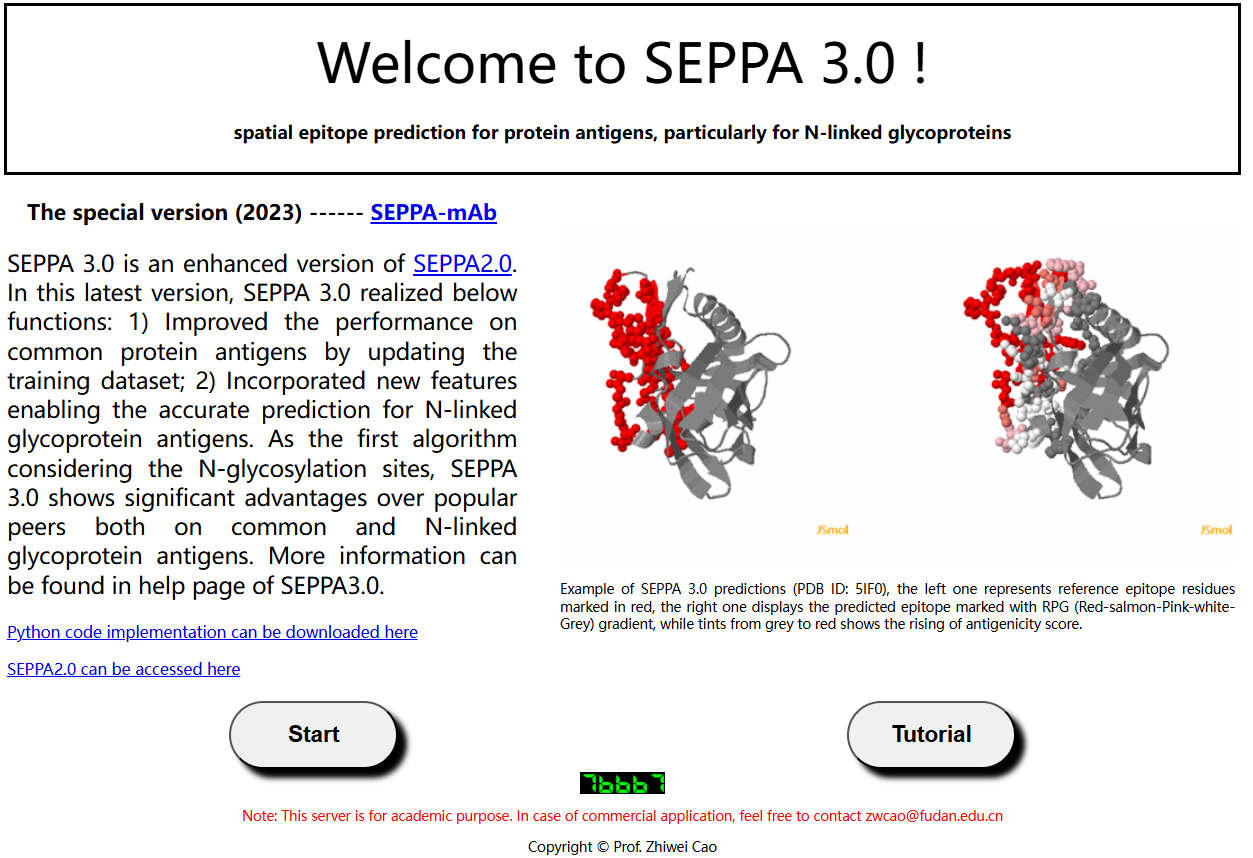


In [ ]:
#@title Calculate, cluster and Visualize SEPPA Epitopes - Antigen only
import os
import py3Dmol
import collections
from Bio.PDB import PDBParser
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import warnings
import numpy as np
from google.colab import files

# Suppress Biopython warnings for cleaner output
warnings.simplefilter('ignore', PDBConstructionWarning)

# --- Helper Functions ---

def parse_seppa_output(seppa_filepath):
    """
    Parses a SEPPA 3.0 output .txt file to get the predicted epitope residues.
    """
    epitope_residues = []
    threshold = 0.089 # Default
    with open(seppa_filepath, 'r') as f:
        for line in f:
            if line.strip().lower().startswith("threshold:"):
                try:
                    threshold = float(line.split(":")[1].strip())
                except (ValueError, IndexError):
                    pass

            if line.startswith(('SEPPA', '---', 'Antigenic', 'Chain:', 'Threshold:', 'Number', 'chainID', '\n')):
                continue

            parts = line.split()
            if len(parts) == 5:
                chain_id, res_seq, res_name, score, location = parts
                if location == 'surface' and float(score) >= threshold:
                    epitope_residues.append({'chain': chain_id, 'resi': int(res_seq)})

    print(f"ℹ️ Found {len(epitope_residues)} potential epitope residues from SEPPA output using threshold >= {threshold}")
    return epitope_residues

def get_residue_coordinates(pdb_path, residue_list):
    """
    Gets the C-alpha coordinate for each residue in the list.
    """
    parser = PDBParser()
    structure = parser.get_structure("antigen", pdb_path)
    coords = {}

    for res_info in residue_list:
        try:
            residue = structure[0][res_info['chain']][res_info['resi']]
            if 'CA' in residue:
                key = (res_info['chain'], res_info['resi'])
                coords[key] = residue['CA'].get_coord()
        except KeyError:
            continue

    return coords

def cluster_residues(residue_coords, cutoff_distance=10.0):
    """
    Clusters residues based on their 3D coordinates using a distance cutoff.
    """
    if not residue_coords:
        return []

    residues = list(residue_coords.items())
    n = len(residues)
    unassigned = list(range(n))
    clusters = []

    while unassigned:
        current_cluster_indices = [unassigned.pop(0)]
        cluster_queue = [current_cluster_indices[0]]

        while cluster_queue:
            current_idx = cluster_queue.pop(0)
            neighbors_found = []

            for other_idx in unassigned:
                dist = np.linalg.norm(residues[current_idx][1] - residues[other_idx][1])
                if dist <= cutoff_distance:
                    neighbors_found.append(other_idx)

            for neighbor_idx in neighbors_found:
                unassigned.remove(neighbor_idx)
                current_cluster_indices.append(neighbor_idx)
                cluster_queue.append(neighbor_idx)

        final_cluster = [residues[i][0] for i in current_cluster_indices]
        clusters.append(final_cluster)

    return clusters

# --- Colab Forms ---
#@markdown ### Clustering Parameter
#@markdown ---
#@markdown **Cutoff Distance (Å):** Residues within this distance will be grouped into the same epitope cluster.
cluster_cutoff = 12.0 #@param {type:"number"}

# --- Main Execution Block ---

print("Please upload your antigen PDB file.")
uploaded_pdb = files.upload()

if not uploaded_pdb:
    print("\n❌ ERROR: No PDB file was uploaded.")
else:
    antigen_pdb_path = next(iter(uploaded_pdb))
    with open(antigen_pdb_path, 'wb') as f:
        f.write(uploaded_pdb[antigen_pdb_path])

    print("\nPlease upload your SEPPA 3.0 output file (.txt).")
    uploaded_seppa = files.upload()

    if not uploaded_seppa:
        print("\n❌ ERROR: No SEPPA output file was uploaded.")
    else:
        seppa_output_path = next(iter(uploaded_seppa))
        with open(seppa_output_path, 'wb') as f:
            f.write(uploaded_seppa[seppa_output_path])

        epitope_residue_list = parse_seppa_output(seppa_output_path)
        residue_coordinates = get_residue_coordinates(antigen_pdb_path, epitope_residue_list)
        epitope_clusters = cluster_residues(residue_coordinates, cluster_cutoff)
        print(f"✅ Clustered residues into {len(epitope_clusters)} distinct epitope 'hotspots'.")

        # --- FIX: Expanded the color list to prevent repeats ---
        colors = [
            'red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta',
            'salmon', 'lime', 'teal', 'gold', 'violet', 'pink', 'deepskyblue',
            'olive', 'chocolate', 'deeppink', 'slateblue', 'seagreen'
        ]

        # 4. Print the formatted output for IgGM, including the unique color
        print("\n--- Epitopes Formatted for IgGM ---")
        for i, cluster in enumerate(epitope_clusters):
            color = colors[i % len(colors)]
            sorted_cluster = sorted(cluster, key=lambda x: (x[0], x[1]))
            res_ids_str = " ".join([str(res[1]) for res in sorted_cluster])
            print(f"epitope {i+1} ({color}): {res_ids_str}")
        print("-----------------------------------")

        # 5. Visualize the clusters
        print("\nGenerating 3D visualization of epitope clusters...")
        with open(antigen_pdb_path, 'r') as f:
            pdb_data = f.read()

        view = py3Dmol.view(width=800, height=500)
        view.addModel(pdb_data, 'pdb')

        view.setStyle({}, {'cartoon': {'color': 'lightgray'}})

        for i, cluster in enumerate(epitope_clusters):
            color = colors[i % len(colors)]
            selection = {'or': [{'chain': res[0], 'resi': res[1]} for res in cluster]}
            view.addStyle(selection, {'stick': {'color': color, 'radius': 0.2}, 'sphere': {'scale': 0.4, 'color': color}})

        view.zoomTo()
        view.show()

# IgGM Design

In [ ]:
#@title Antibody and nanobody Design 🧬
import os
import subprocess
import sys

#@markdown ## 1. Core Inputs
#@markdown ---
#@markdown **--fasta:** Path to your antibody/nanobody-antigen complex FASTA file. The regions you want the model to redesign (CDRs) should be replaced with 'X' characters.
fasta_path = "/content/IgGM/inputs/your_fasta.fasta" #@param {type:"string"}
#@markdown **--antigen:** Path to the corresponding antigen PDB file. This structure provides the context for the antibody design.
antigen_pdb_path = "/content/IgGM/inputs/your_pdb.pdb" #@param {type:"string"}

#@markdown ## 2. Epitope Definition
#@markdown ---
#@markdown **--epitope:** A list of residue numbers on the antigen that the antibody should target.
#@markdown - **Format:** Numbers must be separated by spaces.
#@markdown - **To modify:** Change these numbers to define the specific surface on the antigen you want the new antibody to bind to.
epitope_residues = "14 19 20 34 35 36 37 38 39 40 41 42 43 44 45 46 47 " #@param {type:"string"}

#@markdown ## 3. Sampling and Generation Parameters
#@markdown ---
#@markdown **--num_samples:** The total number of unique antibody designs to generate.
#@markdown - **To modify:** Increase this number if you want more candidates.
num_samples = 211 #@param {type:"number"}
#@markdown **--steps:** The number of sampling steps in the design process.
#@markdown - **To modify:** Higher values may lead to higher quality designs but will take significantly longer. The default of 10 is a good starting point.
steps = 15 #@param {type:"number"}

#@markdown ## 4. Advanced & Output Settings
#@markdown ---
#@markdown **--chunk_size:** Used for large antigens to process the structure in pieces and save memory.
#@markdown - **To modify:** Only decrease this if you encounter out-of-memory errors. The default is usually fine.
chunk_size = 64 #@param {type:"number"}
#@markdown **--max_antigen_size:** If an antigen is larger than this, it will be cropped around the epitope to save resources.
#@markdown - **To modify:** Increase if your antigen is very large and you don't want it to be cropped. Decrease if you are encountering out-of-memory errors. This might be preferred over modifying chunk_size
max_antigen_size = 2000 #@param {type:"number"}
#@markdown **--relax:** If checked, uses Amber relaxation to perform energy minimization on the final designed structures. When running a large number of inference samples it is better to leave this unchecked and process all outputs on this [notebook](https://colab.research.google.com/drive/15puojVxXjo4CvWm1HcpE4talhCu8BRon?usp=sharing) instead.
#@markdown - **Effect:** This significantly improves the physical realism of the structure and prepares it to be used in tools like NanoBinder but adds a lot of time to the end of the process, time is very limited in a free GPU runtime
relax = False #@param {type:"boolean"}
#@markdown **--output:** The directory where the final designed PDB files will be saved.
output_directory = "/content/IgGM/outputs" #@param {type:"string"}


# --- Main Execution Block ---

script_path = "/content/IgGM/design.py"

# --- 1. Validate Inputs ---
if not os.path.exists(script_path):
    print(f"❌ ERROR: The script was not found at '{script_path}'.")
elif not os.path.exists(fasta_path):
    print(f"❌ ERROR: The input FASTA file was not found at '{fasta_path}'.")
elif not os.path.exists(antigen_pdb_path):
    print(f"❌ ERROR: The input PDB file was not found at '{antigen_pdb_path}'.")
else:
    # --- 2. Prepare and Run Command ---
    os.makedirs(output_directory, exist_ok=True)

    command = [
        "python", script_path,
        "--fasta", fasta_path,
        "--antigen", antigen_pdb_path,
        "--output", output_directory,
        "--num_samples", str(num_samples),
        "--steps", str(steps),
        "--chunk_size", str(chunk_size),
        "--max_antigen_size", str(max_antigen_size),
    ]

    # Add the epitope list if provided
    if epitope_residues.strip():
        command.append("--epitope")
        command.extend(epitope_residues.strip().split())

    # Add the relax flag if the checkbox is ticked
    if relax:
        command.append("--relax")

    print(f"▶️ Running command: {' '.join(command)}\n")
    print("--- Script Output (Live) ---")

    full_output = ""
    try:
        # Use subprocess.Popen to stream output in real-time
        process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1)

        for line in iter(process.stdout.readline, ''):
            print(line, end='')
            sys.stdout.flush() # Force immediate printing in Colab

        process.stdout.close()
        return_code = process.wait()

        if return_code != 0:
            print(f"\n❌ ERROR: Script execution failed with return code {return_code}.")
        else:
            print("\n✅ Script executed successfully.")

    except Exception as e:
        print(f"\nAn error occurred while running the script: {e}")

In [ ]:
#@title Visualize and Align IgGM Design Results
import os
import py3Dmol
import collections
import numpy as np
from Bio.PDB import PDBParser, Superimposer, PDBIO
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import warnings
import io

# Suppress Biopython warnings for cleaner output
warnings.simplefilter('ignore', PDBConstructionWarning)

# --- Helper Functions ---

def get_chain_info(pdb_data_string):
    """Gets the chains and the first residue of each for labeling."""
    chain_info = collections.OrderedDict()
    for line in pdb_data_string.splitlines():
        if line.startswith('ATOM'):
            chain_id = line[21]
            if chain_id not in chain_info:
                try:
                    residue_number = int(line[22:26])
                    chain_info[chain_id] = residue_number
                except ValueError:
                    continue
    return chain_info

def align_and_get_rmsd(fixed_pdb_path, moving_pdb_path, align_chain_id='A'):
    """
    Aligns the moving PDB (IgGM output) to the fixed PDB (original antigen)
    using only the C-alpha atoms of the specified antigen chain.
    Returns the aligned PDB as a string and the RMSD value.
    """
    parser = PDBParser()

    try:
        fixed_struct = parser.get_structure("fixed", fixed_pdb_path)
        moving_struct = parser.get_structure("moving", moving_pdb_path)
    except Exception as e:
        print(f"❌ ERROR: Biopython could not parse one of the PDB files: {e}")
        return None, None

    # Create a dictionary of C-alpha atoms from the antigen chain in the fixed structure
    fixed_ca_atoms_dict = {
        atom.get_parent().id: atom
        for atom in fixed_struct.get_atoms()
        if atom.get_name() == 'CA' and atom.get_parent().get_parent().id == align_chain_id
    }

    # Build paired lists of atoms from the antigen chain that exist in BOTH structures
    fixed_atoms = []
    moving_atoms = []
    for atom in moving_struct.get_atoms():
        if atom.get_name() == 'CA' and atom.get_parent().get_parent().id == align_chain_id:
            res_id = atom.get_parent().id
            if res_id in fixed_ca_atoms_dict:
                moving_atoms.append(atom)
                fixed_atoms.append(fixed_ca_atoms_dict[res_id])

    if not fixed_atoms:
        print(f"⚠️ Warning: No common C-alpha atoms found for antigen chain '{align_chain_id}'. Cannot align.")
        return None, None

    print(f"Found {len(fixed_atoms)} common C-alpha atoms on antigen chain '{align_chain_id}' for alignment.")

    # --- Superimpose and calculate RMSD ---
    super_imposer = Superimposer()
    super_imposer.set_atoms(fixed_atoms, moving_atoms)
    rmsd = super_imposer.rms

    # Apply the transformation to the entire moving structure (the full complex)
    super_imposer.apply(moving_struct.get_atoms())

    # --- Save the aligned structure to a string ---
    io_handle = io.StringIO()
    pdb_io = PDBIO()
    pdb_io.set_structure(moving_struct)
    pdb_io.save(io_handle)
    aligned_pdb_string = io_handle.getvalue()

    return aligned_pdb_string, rmsd

def main():
    # --- Colab Forms ---
    #@markdown ### 1. Input Files and Parameters
    #@markdown Path to the **original antigen PDB** file used as input for IgGM.
    original_antigen_pdb = "/content/antigen.pdb" #@param {type:"string"}
    #@markdown Path to the final **output PDB from IgGM** (containing the designed nanobody and antigen).
    iggm_output_pdb = "/content/outputs/iggm_design_0.pdb" #@param {type:"string"}
    #@markdown **Crucial:** Enter the chain ID of the **antigen** to use for alignment.
    antigen_chain_id = "A" #@param {type:"string"}

    if not all([original_antigen_pdb.strip(), iggm_output_pdb.strip(), antigen_chain_id.strip()]):
        print("❌ ERROR: Please fill in all three path/ID fields.")
        return
    if not os.path.exists(original_antigen_pdb):
        print(f"❌ ERROR: Original antigen PDB not found at '{original_antigen_pdb}'.")
        return
    if not os.path.exists(iggm_output_pdb):
        print(f"❌ ERROR: IgGM output PDB not found at '{iggm_output_pdb}'.")
        return

    # --- 1. Align structures and get RMSD ---
    print(f"\nAligning IgGM output to the original antigen based on chain '{antigen_chain_id}'...")
    aligned_pdb_data, rmsd = align_and_get_rmsd(original_antigen_pdb, iggm_output_pdb, antigen_chain_id)

    if not aligned_pdb_data or rmsd is None:
        print("Alignment failed. Halting before visualization.")
        return

    print(f"✅ Alignment complete. RMSD over antigen chain '{antigen_chain_id}': {rmsd:.3f} Å")

    # --- 2. Read file contents and get chain info ---
    with open(original_antigen_pdb, 'r') as f:
        original_pdb_data = f.read()

    original_chains = get_chain_info(original_pdb_data)
    designed_chains = get_chain_info(aligned_pdb_data)

    print("\nGenerating visualizations...")

    # --- Viewer 1: Original Antigen Structure ---
    print("\n--- 1. Original Antigen Structure ---")
    view1 = py3Dmol.view(width=800, height=500)
    view1.addModel(original_pdb_data, 'pdb')
    view1.setStyle({'chain': antigen_chain_id}, {'cartoon': {'color': 'salmon'}})
    for chain, resi in original_chains.items():
        view1.addLabel(f"Chain {chain}", {'fontColor':'white', 'backgroundColor':'black', 'backgroundOpacity':0.7}, {'chain': chain, 'resi': resi})
    view1.zoomTo()
    view1.show()

    # --- Viewer 2: Final IgGM Design (Aligned) ---
    print("\n--- 2. Final IgGM Design ---")
    view2 = py3Dmol.view(width=800, height=500)
    view2.addModel(aligned_pdb_data, 'pdb')
    view2.setStyle({}, {'cartoon': {'colorscheme': 'chain'}})
    for chain, resi in designed_chains.items():
        view2.addLabel(f"Chain {chain}", {'fontColor':'white', 'backgroundColor':'black', 'backgroundOpacity':0.7}, {'chain': chain, 'resi': resi})
    view2.zoomTo()
    view2.show()

    # --- Viewer 3: Overlapped Structures ---
    print(f"\n--- 3. Overlapped Structures (RMSD over antigen: {rmsd:.3f} Å) ---")
    print("(Original antigen in Gray, IgGM design in Color)")
    view3 = py3Dmol.view(width=800, height=500)
    view3.addModel(original_pdb_data, 'pdb')
    view3.setStyle({'model': 0}, {'cartoon': {'color': 'lightgray', 'opacity': 0.8}})

    view3.addModel(aligned_pdb_data, 'pdb')
    view3.setStyle({'model': 1}, {'cartoon': {'colorscheme': 'chain'}})

    view3.zoomTo()
    view3.show()

# Run the main function
main()

In [ ]:
# =============================================
#@title Compress folder and auto-download the ZIP with outputs
# =============================================

import shutil
from google.colab import files

# 1) Path to the folder you want to compress
folder_to_zip = "/content/IgGM/outputs"  # <-- update to your folder

# 2) Archive base name (without .zip)
archive_name = "IgGM_outputs"

# 3) Create the .zip archive
shutil.make_archive(archive_name, 'zip', folder_to_zip)

# 4) Automatically download the archive
files.download(f"{archive_name}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Results Screening

# Nanobodies

For screening your *de novo* designed nanobodies and find the best candidates to validate in the Wet Lab, you can use the [NanoBinder web server](https://nsclbio.jbnu.ac.kr/tools/webserver/). You can find their paper [here](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-025-01040-1).

Instructions on how use the server can be found in supplementary information or be downloaded [here](https://static-content.springer.com/esm/art%3A10.1186%2Fs13321-025-01040-1/MediaObjects/13321_2025_1040_MOESM2_ESM.docx)

Notes:


*   I was not able to access the webserver from Brazil (other countries might face similar issues). To overcome that, I accessed using a vpn connected to a Korean server. I used [1ClickVPN](https://chromewebstore.google.com/detail/1clickvpn-proxy-for-chrom/pphgdbgldlmicfdkhondlafkiomnelnk?hl=en), it is free and you can use it in google chrome. You could try with any other vpn service you want.









**Future Work and Potential**

The current workflow in this notebook successfully implements a powerful pipeline for antibody analysis and design preparation using IgGM. The next frontier is to integrate the complete, end-to-end functional engineering capabilities demonstrated in the groundbreaking work by Yu Kong, Jiale Shi, Fandi Wu, and colleagues.

[Their paper](https://www.biorxiv.org/content/10.1101/2025.05.09.653014v1) introduces TFDesign-sdAb, a framework whose power comes from the synergy of two novel components working together: a specialized generator and an expert ranker. The key innovations that make this approach so successful are:


* A Re-architected IgGM for Framework Design: The authors intelligently modified the IgGM model with a two-phase training strategy. This allows it to optimize not just the CDRs, but also the crucial Framework Regions (FRs), which is essential for engineering new functions like Protein A binding while preserving the antibody's original antigen affinity.


* A Fine-Tuned A2binder for Accurate Ranking: A generative model can create thousands of candidates, but this is only useful if the best ones can be identified. The authors demonstrated that a generic affinity model failed on sdAbs, but after fine-tuning A2binder with a small, specific set of sdAb affinity data, its performance improved dramatically. This expertly adapted ranker is the critical component that filters the vast design space to find the candidates with the highest chance of success by co-validating best candidates with NanoBinder.

The authors' amazing work in combining these innovations led to a remarkable 100% success rate in their specific task: engineering Protein A binding into sdAbs that previously could not.

If the repository containing the specialized IgGM-FR model and, most importantly, the fine-tuned A2binder model with its weights were made public, this Colab notebook could be transformed into a complete, all-in-one tool. It would empower researchers to go directly from an antigen structure to a small, highly enriched set of computationally validated antibody and nanobody designs that are truly ready for wet-lab synthesis and testing, massively accelerating the pace of therapeutic discovery.

# Instructions

**Quick start**
1. Run the firs two cells, this will install condacolab and mount google drive for pyRosetta.
2. Press the run buttum under <a href="#scrollTo=Z7DdqnBEbSiL">Install dependencies</a> section, this will automatically run 17 hidden cells.

**Initial workflow and file pre-processing**

1. Run the cell <a href="#scrollTo=Gymzu66qJQIj">Upload your pdb and clean all non-protein atoms</a>. IgGM does not support non-protein chains nor non-standard residues. Chain names will be displayed along its 3D structure.
2. You can optionally <a href="#scrollTo=1sWrzBQPBv-r">delete chains</a>  that are far away from the epitope. Ideally you migght want to leave all protein chains intact for the model to have as much context as possible. Necessarily for designing or redesigning Antibodies or nanonobodies you wil have to delete the H and L chains (for antibodies) or just the H chain (For nanobodies).

**Chain Identification and CDR masking for redesign**

1. The  <a href="#scrollTo=rqqvcz-GZFOU">first cell</a> under this section will just list all files under `/content/IgGM/inputs`, if you wish to design different antibodies or nanobodies (meaning not present in your orignal PDB file), you can optionally upload the PDB files containing those in the cell above.
2. Run the cell <a href="#scrollTo=ogM7GFIEpdpi">Select File and Classify Chains</a> . This will find and clasify all Light and Heavy chains in the input PDB and number them using the IMTG scheme.
3. Running the cell <a href="#scrollTo=J33q8A6KuZnf">Generate CDR-Masked FASTA File for redesign</a> will generate a fasta file containing only Heavy and Light chains with their CDRs masked with 'X'. You can edit this fasta file by double clicking on it. Files can be accessed through the folder icon on the left. The file location will be printed on the cell's output.
Leaving the file as it is usually OK, but you might want to edit it depending on your goals. You can adjust the CDRs leghts to be designed by either deliting or adding more 'X' in the CDR masked region.

Note: CDRs do not need to be masked for design, if you wish to keep some or all residues within a CDR invariable, replace the masked 'X' for the corresponding residue(s), just be mindfull of its position.
4. For this step you will need to check the output from <a href="#scrollTo=ogM7GFIEpdpi">last cell</a> you will see something like:

--- 🔬 Analysis Results ---

Chain A: Not an antibody variable domain

Chain B: VL (Lambda Light Chain Variable Domain)

Chain C: VH (Heavy Chain Variable Domain)

The output used for epitope calculation must have only one VH and VL or one VHH, The previous cell would have identified which chains are those. VH or VHH chains must be renanmed to H and VL chain must be renamed to L. 3D structure and chain names will b displayed to check that everything is correct

**Chain merging and epitope identification**
1. Run IgGM Chain Merger, generate pre-input FASTA and Visualize, This will generate A PDB and fasta files with the antigen chains merged. IgGM does not have support for multiple chain antigens.  To know the chain IDs to be merged, check:

    --- 2. Renamed PDB ---    
  in the output for <a href="#scrollTo=n_aOlTBDyPba">Renaming PDB Chains for IgGM</a>. This step will generate the input .pdb and .fasta files that you will use in <a href="#scrollTo=MLEELojmZ256">Antibody and nanobody design</a>. The .fasta file **MUST** be edited in order to redesign the CDRs or if you want to design with new antibodies or nanobodies Framework Regions.

*   1.1. If you want to redesign the CDRs: Replace the >H and >L (if any) sequences with the ones masked CDRs in Chain Identification and CDR masking for redesign step 3.

*   1.2. If you want to design an antibody or nanobody with a different Framework region (*Note: It is possible to design a nanobody over the epitope of an antibody and vice-versa*): Open the generated .fasta file and delete the >H and >L sequences (If you plan to design a nanobody over the epitope of an antibody, delete the >L header altogether, if designing a antibody over the epitope of an nanobody, add an L header).

*   1.2.1. Follow the steps in **Chain Identification and CDR masking for redesign** again for your new antibodies or nanobodies. That will generate a new fasta file. Open it and copy the sequences that you will use to replace in the next step.

* 1.2.2 Replace the >H and >L (if any) sequences in your .fasta file generated in step 1 "Merge chains, generate pre-input FASTA and Visualize" with the sequences of your new antibody or nanobody. CDRs must be **masked**

  
2. Calculate and Visualize Epitope: You have 2 options

  Option 1 - You **HAVE** an Antigen-Antibody/Nanobody complex and antigen has more than one chain: Run only cells <a href="#scrollTo=xss5FZCc2iHC">one</a> and <a href="#scrollTo=n_aOlTBDyPba">two</a>.

 Option 2 - You **DO NOT HAVE** an Antigen-Antibody/Nanobody complex, only antigen: Run cell one, follow instructions after cell two, then run cell three.

**IgGM Design**

1.   Modify the core inputs with your correct files path and epitope, optionally modify sampling and generation parameters. All in this <a href="#scrollTo=MLEELojmZ256">cell</a>.
2.   Visualize and Align Design Results running this  <a href="#scrollTo=jnQ3zMMRQZtW&line=1&uniqifier=1">cell</a>.

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence, adjust parameters in **IgGM Design** to reduce memory usage.
* Your browser can block the pop-up for downloading the result file. You can  manually download the result files.


**Bugs**
- If you encounter any bugs related to IgGM, please report the issue to https://github.com/TencentAI4S/IgGM/issues

**License Information**

The original code in this Colab notebook, created by the author, is licensed under the Apache 2.0 License.

This notebook is a fork and the author is frequently monitoring the IgGM repository for updates. The underlying IgGM source code is provided under the PolyForm Noncommercial License 1.0.0, making it free for non-commercial, academic, and personal research purposes. This notebook integrates several external tools and libraries, each with its own licensing terms that must be respected:


* SEPPA 3.0: The web server is provided for academic use only. Commercial applications require contacting the authors at zwcao@fudan.edu.cn.

* PyRosetta: Requires a separate license from Rosetta Commons. It is free for academic and non-profit users but requires a paid license for commercial entities.

* ANARCI: Provided under the permissive BSD 3-Clause License.

* HMMER: Available under the GNU GPLv3.

* PyTorch Geometric (PyG): The library and its components (torch_scatter, torch_sparse, etc.) are provided under the MIT License.

* PyTorch: The core deep learning framework is licensed under a permissive BSD-style License.

* Biopython: Distributed under the liberal Biopython License.

* OpenMM: Provided under the MIT License.

* PDBFixer: Provided under the MIT License.

* py3Dmol: Provided under the MIT License.

* Condacolab: Provided under the MIT License.

**Citations & Acknowledgments**
Please cite the relevant authors and tools in any work that uses this notebook.

Primary Publications:

* For IgGM:

Wang, Rubo et al. "IgGM: A Generative Model for Functional Antibody and Nanobody Design." The Thirteenth International Conference on Learning Representations, 2025.

* For ANARCI:

Dunbar, J. & Deane, C. M. "ANARCI: antigen receptor numbering and receptor classification." Bioinformatics, 32(2), 298–300 (2016).

* For SEPPA 3.0:

Zhou, C., Chen, Z., Zhang, L. et al. "SEPPA 3.0—enhanced spatial epitope prediction enabling glycoprotein antigens." Nucleic Acids Research, 47(W1), W388–W394 (2019).

* For PyRosetta:

Chaudhury, S., Lyskov, S. & Gray, J. J. "PyRosetta: a script-based interface for implementing molecular modeling algorithms using Rosetta." Bioinformatics, 26(5), 689-691 (2010).

Acknowledgments:

* We thank the IgGM team for developing their excellent model and making the code available for non-commercial research.

* We thank the Oxford Protein Informatics Group (OPIG) for creating the indispensable ANARCI tool and the Cao Lab for developing and maintaining the SEPPA 3.0 server.

* A special thanks to David Koes for his awesome py3Dmol plugin, which makes the interactive visualizations in this notebook possible.

* This Colab notebook was created and adapted by Luis Eduardo Figueroa (lef.rivera.2021@aluno.unila.edu.br) for the NANODEN project of the iGEM UNILA-LatAm team. Follow our progress on Instagram: @igem_synfronteras.